In [1]:
from pathlib import Path
import os
cwd_path = Path.cwd(); set_path = str(cwd_path.parent.parent); os.chdir(set_path)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%reload_ext autoreload

In [4]:
from TargetDistributions.DoubleWell import ManyWellEnergy
from FittedModels.utils.plotting_utils import plot_samples_vs_contours_many_well

In [5]:
from FittedModels.Models.FlowModel import FlowModel
from AIS_train.train_AIS import AIS_trainer
from ImportanceSampling.VanillaImportanceSampler import VanillaImportanceSampling
from FittedModels.utils.plotting_utils import plot_history, plot_distributions, plot_samples

import matplotlib.pyplot as plt
import torch
from Utils.plotting_utils import plot_func2D, plot_distribution
from Utils.numerical_utils import MC_estimate_true_expectation
from Utils.numerical_utils import quadratic_function as expectation_function
torch.set_default_dtype(torch.float64)

def plotter(*args, **kwargs):
    # wrap plotting function like this so it displays during training
    plot_samples_vs_contours_many_well(*args, **kwargs)
    plt.show()

In [6]:
dim = 8
target = ManyWellEnergy(dim=dim, a=-0.5, b=-6)

In [7]:
n_samples_expectation = int(1e4)
n_samples=int(1e4)

In [8]:
t = torch.cuda.get_device_properties(0).total_memory
print(t)
r = torch.cuda.memory_reserved(0) 
print(r)
a = torch.cuda.memory_allocated(0)
print(a)
f = r-a  # free inside reserved
print(f)

11996954624
0
0
0


# Visualisation

## Vanilla IS with the flow

In [9]:
learnt_sampler = FlowModel(x_dim=dim, scaling_factor=2.0, flow_type="RealNVP", n_flow_steps=60)
vanilla_IS = VanillaImportanceSampling(sampling_distribution=learnt_sampler, target_distribution=target)
expectation_vanilla, info_dict_vanilla = \
vanilla_IS.calculate_expectation(n_samples_expectation, expectation_function=expectation_function)
print(f"ESS is {info_dict_vanilla['effective_sample_size']/n_samples_expectation}, \
      var is {torch.var(info_dict_vanilla['normalised_sampling_weights'])}")

ESS is 0.00011649619261519366,       var is 8.583829906447879e-05


In [10]:
del(vanilla_IS)
del(info_dict_vanilla)

## Hamiltonian HMC

In [11]:
learnt_sampler = FlowModel(x_dim=dim, scaling_factor=2.0, flow_type="RealNVP", n_flow_steps=60)
tester = AIS_trainer(target, learnt_sampler, loss_type="DReG", n_distributions=15, n_steps_transition_operator=3,
                    step_size=0.1, transition_operator="HMC", train_AIS_params=False, learnt_dist_kwargs={"lr": 1e-4},
                    importance_param_lr=1e-4, HMC_inner_steps=6)
tester.loss = lambda x: torch.zeros(1).to(x.device) # train likelihood only

# Train

In [12]:
expectation_before, info_dict_before = tester.AIS_train.calculate_expectation(n_samples_expectation,
                                                                    expectation_function=expectation_function)
print(info_dict_before['effective_sample_size'].item() / n_samples_expectation)

0.010323104557850175


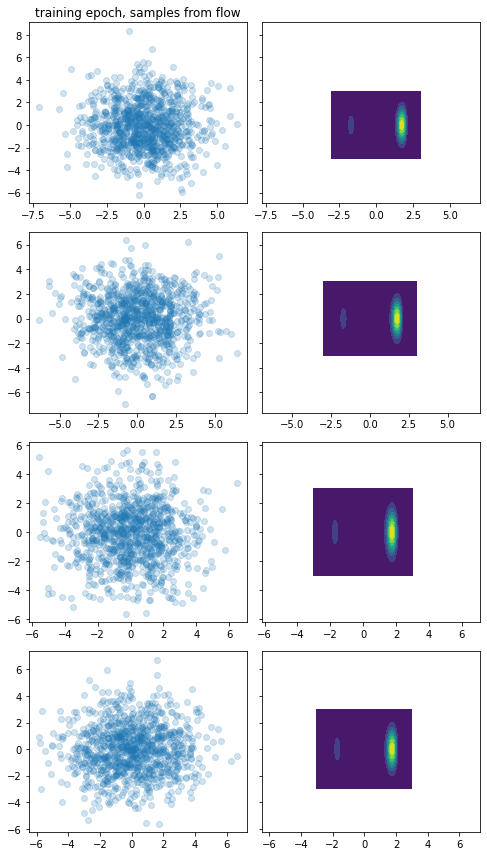

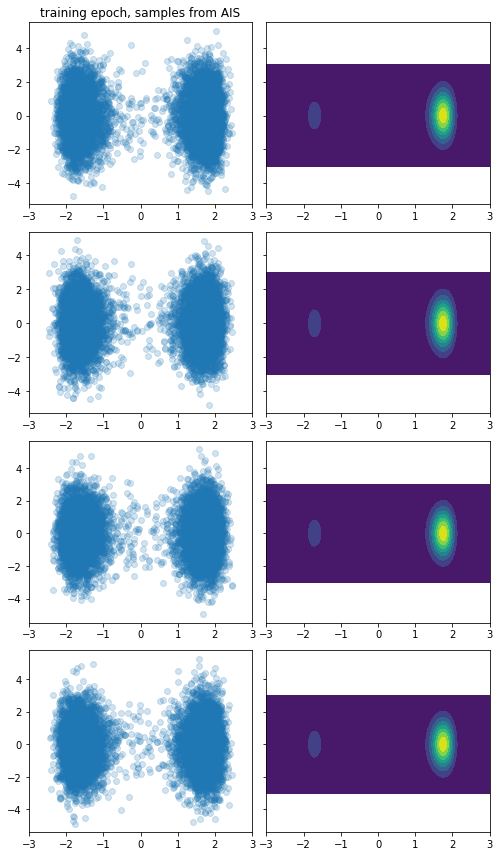

In [13]:
plot_samples_vs_contours_many_well(tester, n_samples=1000,
                                      title=f"training epoch, samples from flow")
plot_samples_vs_contours_many_well(tester, n_samples=None,
                                      title=f"training epoch, samples from AIS",
                                      samples_q=info_dict_before["samples"])

In [ ]:
history = tester.train(400, batch_size=int(1e3), intermediate_plots=True, n_plots=4, plotting_func=plotter)

  0%|          | 0/400 [00:00<?, ?it/s]

In [ ]:
expectation, info_dict = tester.AIS_train.calculate_expectation(n_samples_expectation,
                                                                    expectation_function=expectation_function)
print(info_dict['effective_sample_size'].item() / n_samples_expectation)

In [ ]:
plot_history(history)

In [ ]:
plot_samples_vs_contours_many_well(tester, n_samples=3000,
                                      title=f"training epoch, samples from flow")
plot_samples_vs_contours_many_well(tester, n_samples=None,
                                      title=f"training epoch, samples from AIS",
                                      samples_q=info_dict["samples"])

# Metrpolis-Hastings

In [ ]:
learnt_sampler = FlowModel(x_dim=dim, scaling_factor=2.0, flow_type="RealNVP", n_flow_steps=60)
tester = AIS_trainer(target, learnt_sampler, loss_type="DReG", n_distributions=20, n_steps_transition_operator=3,
                    step_size=0.5, transition_operator="Metropolis", train_AIS_params=True, learnt_dist_kwargs={"lr": 1e-4},
                    importance_param_lr=1e-3)

In [ ]:
expectation_before, info_dict_before = tester.AIS_train.calculate_expectation(n_samples_expectation,
                                                                    expectation_function=expectation_function)
print(info_dict_before['effective_sample_size'].item() / n_samples_expectation)

In [ ]:
plot_samples_vs_contours_many_well(tester, n_samples=1000,
                                      title=f"training epoch, samples from flow")
plot_samples_vs_contours_many_well(tester, n_samples=None,
                                      title=f"training epoch, samples from AIS",
                                      samples_q=info_dict_before["samples"])

# Train

In [ ]:
learnt_sampler = FlowModel(x_dim=dim, scaling_factor=2.0, flow_type="RealNVP", n_flow_steps=60)
tester = AIS_trainer(target, learnt_sampler, loss_type="DReG", n_distributions=20, n_steps_transition_operator=3,
                    step_size=0.5, transition_operator="Metropolis", train_AIS_params=True, learnt_dist_kwargs={"lr": 1e-4},
                    importance_param_lr=1e-4)

In [ ]:
history = tester.train(100, batch_size=int(1e3), intermediate_plots=True, n_plots=4, plotting_func=plotter)

In [ ]:
plot_samples_vs_contours_many_well(tester, n_samples=1000,
                                      title=f"training epoch, samples from flow")
plot_samples_vs_contours_many_well(tester, n_samples=None,
                                      title=f"training epoch, samples from AIS",
                                      samples_q=info_dict_before["samples"])

In [ ]:
history = tester.train(1000, batch_size=int(1e3), intermediate_plots=True, n_plots=4, plotting_func=plotter)

In [ ]:
plot_samples_vs_contours_many_well(tester, n_samples=1000,
                                      title=f"training epoch, samples from flow")
plot_samples_vs_contours_many_well(tester, n_samples=None,
                                      title=f"training epoch, samples from AIS",
                                      samples_q=info_dict_before["samples"])